In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, RepeatedKFold

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Getting data from scraped csv file

In [2]:
df = pd.read_csv("WineData.csv")
df.head()

,Unnamed: 0,Id,Name,Price,Rating,NumRatings,Type,StyleName,Year,Body,Acidity,Vintage,Nat,Region,Country,Size,Winery
0,0,1416855,Bota Box Redvolution 2011,5.02,3.5,1957,1,Californian Red Blend,2011,4,3,0,0,California,United States,500,Bota Box
1,1,88766858,Crane Lake Cabernet Sauvignon 2016,5.49,3.2,3101,1,Californian Cabernet Sauvignon,2016,4,3,0,0,California,United States,750,Crane Lake
2,2,141258254,Crane Lake Pinot Noir 2016,5.49,3.2,1466,1,Californian Pinot Noir,2016,3,3,0,0,California,United States,750,Crane Lake
3,3,157294384,Oro Bello Rosé Gold 2017,5.25,3.8,50,4,Californian Rosé,2017,3,2,0,0,California,United States,750,Oro Bello
4,4,1395988,Sutter Home White Zinfandel 2012,6.67,3.6,6112,4,NONE,2012,-1,-1,0,0,St. Helena,United States,750,Sutter Home


# Cleaning the data

In [3]:
df.columns

Index(['Unnamed: 0', 'Id', 'Name', 'Price', 'Rating', 'NumRatings', 'Type',
       'StyleName', 'Year', 'Body', 'Acidity', 'Vintage', 'Nat', 'Region',
       'Country', 'Size', 'Winery'],
      dtype='object')

In [4]:
#Drop all categorical/useless columns
numeric = df.drop(columns=['Unnamed: 0', 'Id', 'Name', 'StyleName', 'Region', 'Winery'])
#Drop all records with body or acidity = -1
numeric = numeric.loc[~((numeric["Body"] == -1) | (numeric["Acidity"] == -1) | (numeric["Year"] == 0))]
numeric.head()

,Price,Rating,NumRatings,Type,Year,Body,Acidity,Vintage,Nat,Country,Size
0,5.02,3.5,1957,1,2011,4,3,0,0,United States,500
1,5.49,3.2,3101,1,2016,4,3,0,0,United States,750
2,5.49,3.2,1466,1,2016,3,3,0,0,United States,750
3,5.25,3.8,50,4,2017,3,2,0,0,United States,750
6,7.08,3.7,7880,4,2018,3,2,0,0,United States,750


In [5]:
#Making dummy columns for each country
countries = numeric.Country.unique()

for country in countries:
    numeric[country] = np.where(numeric["Country"] == country, 1, 0)

In [6]:
#Remove country column and make final cleaned data
data = numeric.drop(columns=["Country"])
data.reset_index(inplace=True,drop=True)
data.head()

,Price,Rating,NumRatings,Type,Year,Body,Acidity,Vintage,Nat,Size,...,NONE,Greece,Uruguay,Mexico,New Zealand,Germany,Hungary,Austria,Brazil,United Kingdom
0,5.02,3.5,1957,1,2011,4,3,0,0,500,...,0,0,0,0,0,0,0,0,0,0
1,5.49,3.2,3101,1,2016,4,3,0,0,750,...,0,0,0,0,0,0,0,0,0,0
2,5.49,3.2,1466,1,2016,3,3,0,0,750,...,0,0,0,0,0,0,0,0,0,0
3,5.25,3.8,50,4,2017,3,2,0,0,750,...,0,0,0,0,0,0,0,0,0,0
4,7.08,3.7,7880,4,2018,3,2,0,0,750,...,0,0,0,0,0,0,0,0,0,0


# TODO: Remove Outliers

# Linear Regression on log price

In [7]:
#Create X and y
#Create log price column
data['log_price'] = np.log(data["Price"])

#X is every column but log price, y is only log price
X = data.drop(columns=["log_price","Price"])
y = data[["log_price"]].values.ravel()
X.head()

,Rating,NumRatings,Type,Year,Body,Acidity,Vintage,Nat,Size,United States,...,NONE,Greece,Uruguay,Mexico,New Zealand,Germany,Hungary,Austria,Brazil,United Kingdom
0,3.5,1957,1,2011,4,3,0,0,500,1,...,0,0,0,0,0,0,0,0,0,0
1,3.2,3101,1,2016,4,3,0,0,750,1,...,0,0,0,0,0,0,0,0,0,0
2,3.2,1466,1,2016,3,3,0,0,750,1,...,0,0,0,0,0,0,0,0,0,0
3,3.8,50,4,2017,3,2,0,0,750,1,...,0,0,0,0,0,0,0,0,0,0
4,3.7,7880,4,2018,3,2,0,0,750,1,...,0,0,0,0,0,0,0,0,0,0


# Linear Regression with scaled data

In [8]:
#Scale X
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

reg = LinearRegression().fit(X_scaled, y)
reg.score(X_scaled, y)

0.6799687472224125

In [9]:
np.exp(reg.predict(X_scaled))

array([  7.05338031,   5.3534978 ,   6.26881321, ..., 122.50125023,
       147.41339706,  40.36335267])

# PCA Linear Regression with scaling

In [10]:
#Scale X
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

#Transform X
pca_scaled = PCA(n_components=len(list(X_scaled.columns)))
X_transformed = pca_scaled.fit_transform(X_scaled)
X_transformed = X_transformed[:, :15]

#Train on X scaled and transformed
reg = LinearRegression().fit(X_transformed, y)
reg.score(X_transformed, y)

0.5371966901283736

In [11]:
np.exp(reg.predict(X_transformed[:,:]))

array([ 8.42996422,  7.70594391,  8.08955904, ..., 66.45593336,
       66.94631131, 26.27288416])

# Straight Gradient Boosting

In [12]:
reg = GradientBoostingRegressor().fit(X, y)
reg.score(X, y)

0.9194966787625258

In [13]:
np.exp(reg.predict(X))

array([  7.88316275,   9.05999147,   9.13010406, ..., 436.81829434,
       300.53741959,  22.69975446])

# GradientBoosting regression with scaling

In [14]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

reg = GradientBoostingRegressor().fit(X_scaled, y)
reg.score(X_scaled, y)

0.9194966787625258

In [15]:
np.exp(reg.predict(X_scaled))

array([  7.88316275,   9.05999147,   9.13010406, ..., 436.81829434,
       300.53741959,  22.69975446])

# PCA GradientBoosting regression with scaling

In [16]:
#Scale X
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

#Transform X
pca_scaled = PCA(n_components=len(list(X_scaled.columns)))
X_transformed = pca_scaled.fit_transform(X_scaled)
X_transformed = X_transformed[:, :10]

#Train on X scaled and transformed
reg = GradientBoostingRegressor().fit(X_transformed, y)
reg.score(X_transformed, y)

0.9074566551141494

In [17]:
np.exp(reg.predict(X_transformed[:,:10]))

array([ 10.27943425,   9.9137894 ,  10.33711909, ..., 395.87033649,
       329.6152157 ,  21.04016726])

# PCA RandomForest regression with scaling

In [18]:
#Scale X
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

#Transform X
pca_scaled = PCA(n_components=len(list(X_scaled.columns)))
X_transformed = pca_scaled.fit_transform(X_scaled)
X_transformed = X_transformed[:, :10]

#Train on X scaled and transformed
reg = RandomForestRegressor().fit(X_transformed, y)
reg.score(X_transformed, y)

0.9848417734733748

In [19]:
np.exp(reg.predict(X_transformed[:,:10]))

array([  6.10652598,   6.20073283,   6.93349578, ..., 414.36750613,
       333.33589005,  15.28276686])

# PCA Bagging regression with scaling

In [20]:
#Scale X
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

#Transform X
pca_scaled = PCA(n_components=len(list(X_scaled.columns)))
X_transformed = pca_scaled.fit_transform(X_scaled)
X_transformed = X_transformed[:, :10]

#Train on X scaled and transformed
reg = BaggingRegressor().fit(X_transformed, y)
reg.score(X_transformed, y)

0.9809503178024419

In [ ]:
np.exp(reg.predict(X_transformed[:,:10]))

# TODO
- Do each regression technique for all models side by side
    - r squared versus model type
- Cross validation on "good" models
- Final model analysis

# Linear Regression Observations
Straight linear regression 

# KMeans Clustering

In [ ]:
index = len(data)*(2/3)
X_train, X_test = data.loc[:index,:], data.loc[index:,:]

In [ ]:
X_train, X_test

In [ ]:
#Kmeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_train)

In [ ]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = X_train.index.values
cluster_map['cluster'] = kmeans.labels_

cluster_indexs = {}
for cluster in range(10):
    cluster_indexs[cluster] = cluster_map[cluster_map.cluster == cluster].data_index.values
cluster_indexs

# Regression Analysis

>LinearRegression: ideal=0.306, cv=0.305
>Ridge: ideal=0.306, cv=0.305
>Lasso: ideal=0.656, cv=0.657
>DecisionTreeRegressor: ideal=0.108, cv=0.107
>BaggingRegressor: ideal=0.074, cv=0.073
>RandomForestRegressor: ideal=0.071, cv=0.070
>GradientBoostingRegressor: ideal=0.078, cv=0.077
Correlation: 1.000


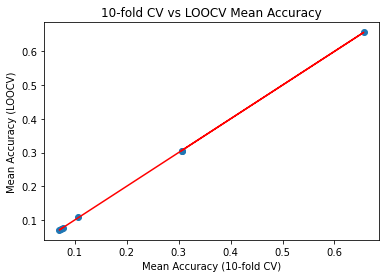

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA

def clean_dataset(df):
    #Drop all categorical/useless columns
    numeric = df.drop(columns=['Unnamed: 0', 'Id', 'Name', 'StyleName', 'Region', 'Winery'])
    #Drop all records with body or acidity = -1
    numeric = numeric.loc[~((numeric["Body"] == -1) | (numeric["Acidity"] == -1) | (numeric["Year"] == 0))]
    numeric.head()

    #Making dummy columns for each country
    countries = numeric.Country.unique()

    for country in countries:
        numeric[country] = np.where(numeric["Country"] == country, 1, 0)

    #Remove country column and make final cleaned data
    data = numeric.drop(columns=["Country"])
    data.reset_index(inplace=True,drop=True)
    return data

def get_dataset(scale=False, pca=False, n_pc=15):
    df = pd.read_csv("WineData.csv")
    df_cleaned = clean_dataset(df)

    #Create X and y
    #Create log price column
    df_cleaned['log_price'] = np.log(df_cleaned["Price"])

    #X is every column but log price, y is only log price
    X = df_cleaned.drop(columns=["log_price","Price"])
    y = df_cleaned[["log_price"]].values.ravel()

    if scale:
        #Scale the data
        scaler = StandardScaler().fit(X)
        X_scaled = scaler.transform(X)
        X = pd.DataFrame(X_scaled, columns=X.columns)

    if pca:
        #PCA transform the data
        pca_scaled = PCA(n_components=len(list(X.columns)))
        X_transformed = pca_scaled.fit_transform(X)
        X = X_transformed[:, :n_pc]

    return X, y

# get a list of models to evaluate
def get_models():
    models = list()
    models.append(LinearRegression())
    models.append(Ridge())
    models.append(Lasso())
    models.append(DecisionTreeRegressor())
    models.append(BaggingRegressor())
    models.append(RandomForestRegressor())
    models.append(GradientBoostingRegressor())
    return models

def scoring(estimator, X, y):
    y_hat = estimator.predict(X)
    return np.mean((y_hat-y)**2)

# evaluate the model using a given test condition
def evaluate_model(cv, model):
    # get the dataset
    #X, y = get_dataset(scale=True,pca=True) #Which dataset? scale, pca params
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    # return scores
    return np.mean(scores)

X,y = get_dataset(scale=True, pca = True)

# define test conditions
#ideal_cv = LeaveOneOut()
ideal_cv = KFold(n_splits=100, shuffle=True, random_state=1)
cv = KFold(n_splits=10, shuffle=True, random_state=1)
# get the list of models to consider
models = get_models()
# collect results
ideal_results, cv_results = list(), list()
# evaluate each model
for model in models:
    # evaluate model using each test condition
    cv_mean = evaluate_model(cv, model)
    ideal_mean = evaluate_model(ideal_cv, model)
    # check for invalid results
    if np.isnan(cv_mean) or np.isnan(ideal_mean):
        continue
    # store results
    cv_results.append(cv_mean)
    ideal_results.append(ideal_mean)
    # summarize progress
    print('>%s: ideal=%.3f, cv=%.3f' % (type(model).__name__, ideal_mean, cv_mean))
# calculate the correlation between each test condition
corr, _ = pearsonr(cv_results, ideal_results)
print('Correlation: %.3f' % corr)
# scatter plot of results
plt.scatter(cv_results, ideal_results)
# plot the line of best fit
coeff, bias = np.polyfit(cv_results, ideal_results, 1)
line = coeff * np.asarray(cv_results) + bias
plt.plot(cv_results, line, color='r')
# label the plot
plt.title('10-fold CV vs LOOCV Mean Accuracy')
plt.xlabel('Mean Accuracy (10-fold CV)')
plt.ylabel('Mean Accuracy (LOOCV)')
# show the plot
plt.show()

In [42]:
#Looking at constant variance for each model using a validation set

#Split into train and test sets
index = int(1/2*len(X))
X_train, X_test = X[:index,:], X[index+1:,:]
y_train, y_test = y[:index], y[index+1:]

LinearRegression
train score : 0.5980538542981442
test score : 0.2557367801808851


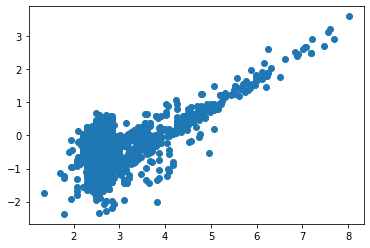

Ridge
train score : 0.598053816349285
test score : 0.25616332302572875


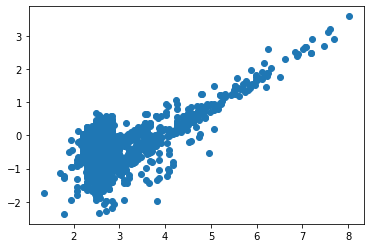

Lasso
train score : 0.0
test score : -0.012101135096789006


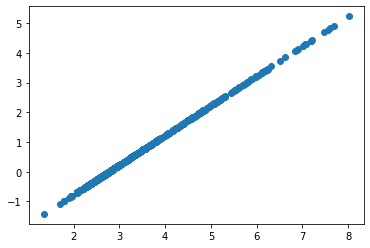

DecisionTreeRegressor
train score : 1.0
test score : 0.5153361274027956


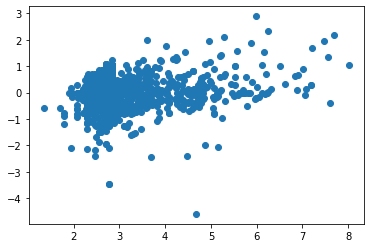

BaggingRegressor
train score : 0.9813266495331623
test score : 0.5449073952898444


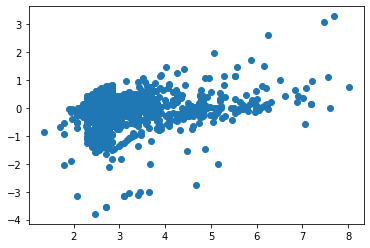

RandomForestRegressor
train score : 0.9866952697666005
test score : 0.633625813914986


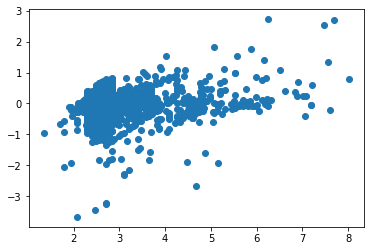

GradientBoostingRegressor
train score : 0.9350071170489032
test score : 0.6827241004838454


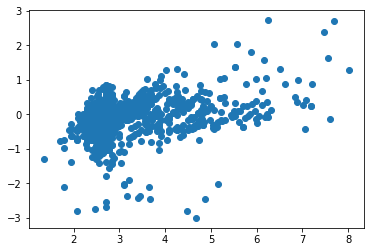

In [43]:
for model in models:
    print(type(model).__name__)
    model.fit(X_train,y_train)
    print(f"train score : {model.score(X_train, y_train)}\ntest score : {model.score(X_test, y_test)}")
    y_hat = model.predict(X_test)
    plt.scatter(y_test,y_test-y_hat)
    plt.show()